# Attempting to extract params from multi-layered samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractorNKD

[((3.46+0.01j), 0.0005), ((2.5+0.015j), 0.00025)]


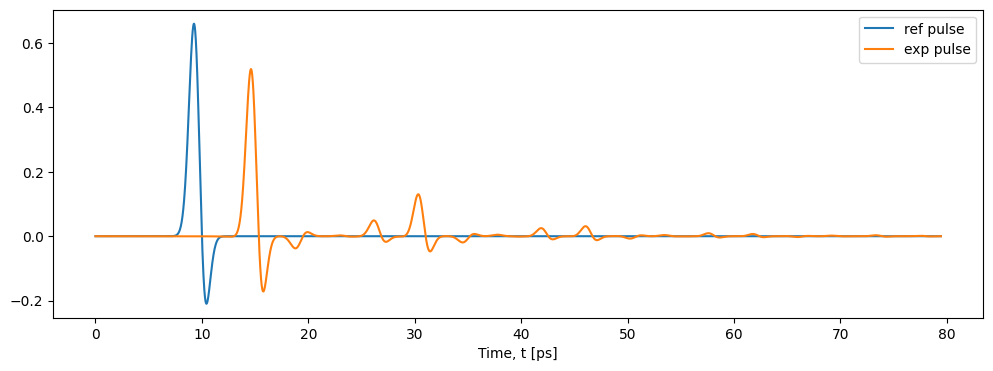

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 0.5e-3
n2, k2, d2= 2.5, 0.015, 0.25e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Test General model to fit all 3 parameters

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.34, 3.54)
Layer 1 - k ∈ (0.004999999999999999, 0.025)
Layer 1 - D ∈ (0.00045, 0.0007499999999999999)
Layer 2 - n ∈ (2.35, 2.5500000000000003)
Layer 2 - k ∈ (0.007000000000000001, 0.027000000000000003)
Layer 2 - D ∈ (0.00015, 0.00045)
[((3.54+0.004999999999999999j), 0.0005001603814828097), ((2.5500000000000003+0.007000000000000001j), 0.00021723023871709837)]


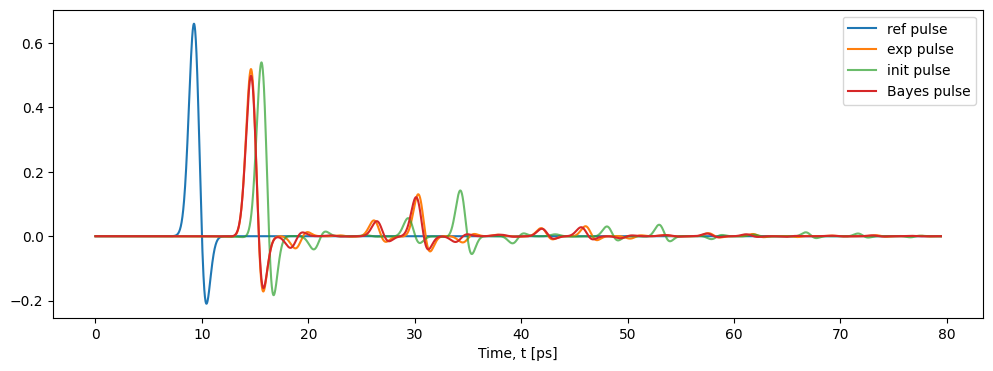

In [3]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

layers_init = [(3.44+1j*0.015, 0.6e-3), (2.45+1j*0.017, 0.3e-3)]

initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractorNKD(reference_pulse, experimental_pulse, deltat, layers_init)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=60)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, initial_pulse, label='init pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [4]:
# TODO: show residuals between (init, true) and (bayes, true)

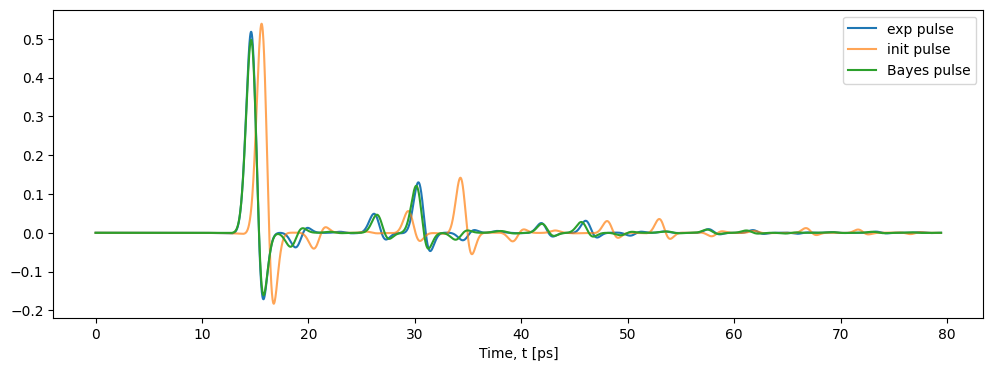

In [5]:
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, initial_pulse, label='init pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [7]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.01)
results = LE.optimize(num_iterations=100, updates=5 , alpha=1)

layer1 = results[0]
layer2 = results[1]
optim_params = [(layer1[0]+1j*layer1[1], layer1[2]), (layer2[0]+1j*layer2[1], layer2[2])]

_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='opt pulse')
plt.xlabel('Time, t [ps]')
plt.show()

Fine-tuning 6 parameters for 100 iterations.
Iteration 4, Loss: 8.568794e-03, Layer 0: n=3.5337, k=0.00480, D=498.62 µm | Layer 1: n=2.5508, k=-0.00136, D=218.89 µm
Iteration 9, Loss: 7.029990e-03, Layer 0: n=3.5325, k=0.01885, D=500.69 µm | Layer 1: n=2.5608, k=0.00035, D=223.14 µm
Iteration 14, Loss: 5.449538e-03, Layer 0: n=3.5226, k=0.01668, D=499.03 µm | Layer 1: n=2.5640, k=-0.01525, D=226.67 µm
Iteration 19, Loss: 4.401333e-03, Layer 0: n=3.5106, k=0.02397, D=496.99 µm | Layer 1: n=2.5656, k=-0.01733, D=230.51 µm
Iteration 24, Loss: 3.386315e-03, Layer 0: n=3.5001, k=0.02818, D=496.49 µm | Layer 1: n=2.5683, k=-0.01960, D=235.27 µm
Iteration 29, Loss: 2.733751e-03, Layer 0: n=3.4876, k=0.02534, D=495.98 µm | Layer 1: n=2.5664, k=-0.02422, D=239.86 µm
Iteration 34, Loss: 1.967574e-03, Layer 0: n=3.4745, k=0.02491, D=496.08 µm | Layer 1: n=2.5583, k=-0.01952, D=243.69 µm
Iteration 39, Loss: 1.546624e-03, Layer 0: n=3.4637, k=0.02165, D=497.84 µm | Layer 1: n=2.5455, k=-0.01032, D=

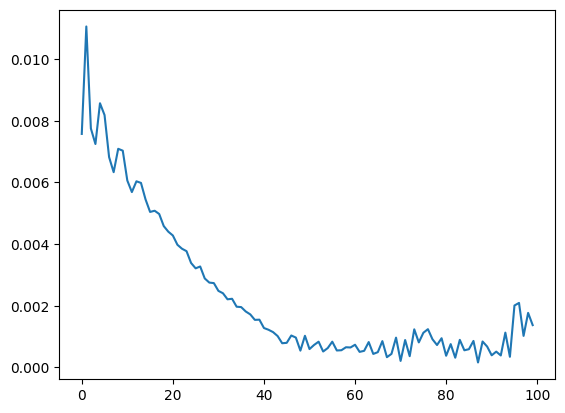

In [18]:
plt.plot(LE.loss_history)